In [1]:
import math
import numpy as np
import pandas as pd
from mapie.classification import MapieClassifier
from mapie.metrics import classification_coverage_score, classification_mean_width_score
import matplotlib.pyplot as plt

from src.model import MockModel
from src.utils import strip_label, index_for_arange
import src.plot as plot
from src.eval import (
    adjusted_classification_x_width_score,
    classification_x_width_score,
    size_stratified_classification_coverage_score,
    cq_stats,
    cq_width_score,
    set_size_equals,
)
from src.heuristics import TopKSelector, HeuristicCutoffSelector, TopKCutoffSelector

In [2]:
data_dir = 'data/banking77/bert/'
N_INTENTS = 77

df_train_preds = pd.read_csv(data_dir + "train_predictions.csv", encoding="ISO-8859-1")
df_test_preds = pd.read_csv(data_dir + "test_predictions.csv", encoding="ISO-8859-1")
df_calibration_preds = pd.read_csv(data_dir + "calibration_predictions.csv", encoding="ISO-8859-1")

labels = pd.read_csv(data_dir+'/labels.csv', header=0, names=['index','label'])
labels = list(labels.label)

In [3]:
df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]

(7502, 2501, 3080)

In [4]:
sum([df_train_preds.shape[0], df_calibration_preds.shape[0], df_test_preds.shape[0]])

13083

In [5]:
df_train = df_train_preds.reset_index().rename(columns={'index': 'utterance'})
df_test = df_test_preds.reset_index().rename(columns={'index': 'utterance'})
df_calibration = df_calibration_preds.reset_index().rename(columns={'index': 'utterance'})

df_train['utterance'] = df_train['utterance'].apply(lambda h: 'train_' + str(h))
df_test['utterance'] = df_test['utterance'].apply(lambda h: 'test_' + str(h))
df_calibration['utterance'] = df_calibration['utterance'].apply(lambda h: 'cal_' + str(h))

In [6]:
df_train['utterance'] = df_train['utterance'].astype(str)
df_test['utterance'] = df_test['utterance'].astype(str)
df_calibration['utterance'] = df_calibration['utterance'].astype(str)

In [7]:
# fullset = pd.concat([df_train, df_test, df_calibration], ignore_index=True).drop_duplicates(['utterance'])
fullset = pd.concat([df_test, df_calibration], ignore_index=True)
assert fullset.utterance.value_counts().max() == 1, "Hashes/utterances should be unique in full set"
fullset = fullset.drop(['label', 'hash', 'text'], axis=1)
fullset.head()

,utterance,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,...,label_67,label_68,label_69,label_70,label_71,label_72,label_73,label_74,label_75,label_76
0,test_0,0.001540,0.000302,0.000882,0.000911,0.000092,0.000975,0.000073,0.000308,0.000253,...,0.001150,0.000325,0.003240,0.001120,0.001470,0.000426,0.002310,0.000188,0.000119,0.000038
1,test_1,0.000187,0.000056,0.000440,0.000036,0.000026,0.000355,0.000046,0.000368,0.000032,...,0.000144,0.000132,0.000187,0.000071,0.000161,0.000029,0.000294,0.000068,0.000023,0.000008
2,test_2,0.000080,0.000055,0.000282,0.000035,0.000024,0.000258,0.000031,0.000263,0.000041,...,0.000161,0.000081,0.000238,0.000069,0.000175,0.000032,0.000357,0.000067,0.000019,0.000004
3,test_3,0.000367,0.000278,0.000541,0.000037,0.000167,0.000518,0.000035,0.000593,0.000133,...,0.001950,0.000262,0.001480,0.000123,0.000630,0.000130,0.000645,0.000512,0.000072,0.000006
4,test_4,0.000100,0.000057,0.000324,0.000023,0.000028,0.000280,0.000022,0.000283,0.000030,...,0.000228,0.000080,0.000190,0.000053,0.000161,0.000026,0.000269,0.000083,0.000020,0.000004


In [8]:
X_train = fullset[['utterance']]
X_calib = df_calibration[['utterance']]
X_test = df_test[['utterance']]

a_start = 0.01
a_stop = .4
a_step = 0.01
alpha = np.arange(a_start, a_stop, a_step)

max_ps_size = math.ceil(N_INTENTS * .25)
max_ps_size = 7

target_alpha = .05
target_index = index_for_arange(a_start, a_step ,target_alpha)

In [9]:
model = MockModel(fullset, 'utterance', softmax=False)
model.fit(X_test, df_test['label'])
y_test = df_test['label'].apply(lambda lbl: list(model.classes_).index(lbl))

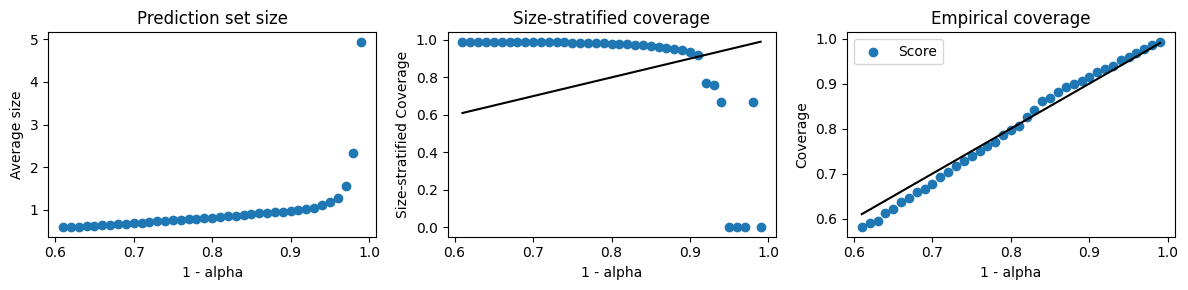

(0.9600649350649351, 1.183116883116883, 0.0, 2736, 1.1745773732119635)

In [10]:
mapie_score = MapieClassifier(estimator=model, cv="prefit", method="score", random_state=3)
mapie_score.fit(X_calib, df_calibration['label'])
y_pred_score, y_ps_score = mapie_score.predict(X_test, alpha=alpha)


coverages_score = [
    classification_coverage_score(y_test, y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_score = [
    classification_mean_width_score(y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_score = [
    adjusted_classification_x_width_score(y_ps_score[:, :, i], np.mean,max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_score = [
    size_stratified_classification_coverage_score(y_test, y_ps_score[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_score, widths_mean_score, "Score", ssc_score, True, "banking77", "bert")

coverages_score[target_index], widths_mean_score[target_index], ssc_score[target_index], set_size_equals(y_ps_score[:,:,target_index], 1), adjusted_width_score[target_index]

In [11]:
y_ps_t = y_ps_score[:, :, target_index]
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], cq_width_score(y_ps_t)

(0.8883116883116883, 2.63953488372093)

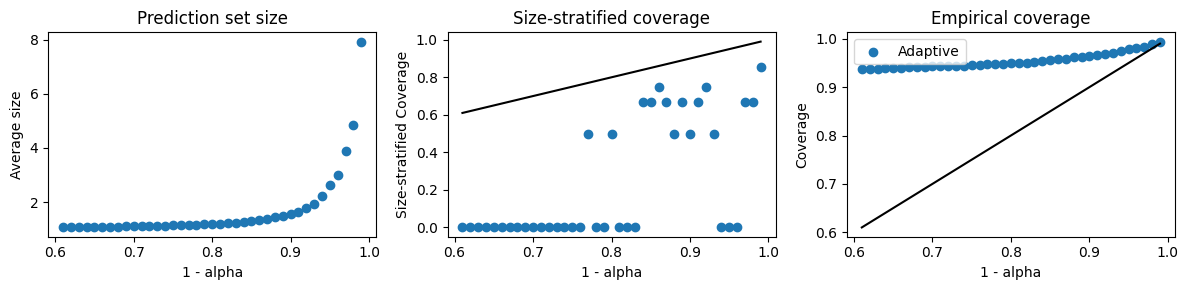

(0.9785714285714285, 2.647077922077922, 0.0, 2408, 1.2680744452397996)

In [12]:
mapie_cum = MapieClassifier(estimator=model, cv="prefit", method="cumulated_score", random_state=3)
mapie_cum.fit(X_calib, df_calibration['label'])
y_pred_cum, y_ps_cum = mapie_cum.predict(X_test, alpha=alpha)

coverages_cum = [
    classification_coverage_score(y_test, y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_cum = [
    classification_mean_width_score(y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_cum = [
    adjusted_classification_x_width_score(y_ps_cum[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_cum = [
    size_stratified_classification_coverage_score(y_test, y_ps_cum[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_cum, widths_mean_cum, "Adaptive", ssc_cum, True, "banking77", "bert")
coverages_cum[target_index], widths_mean_cum[target_index], ssc_cum[target_index], set_size_equals(y_ps_cum[:,:,target_index], 1), adjusted_width_cum[target_index]

In [13]:
y_ps_t = y_ps_cum[:, :, target_index]
set_size_equals(y_ps_t, 1)/y_ps_t.shape[0], y_ps_t[y_ps_t.sum(axis=1) > 1].sum(axis=1).mean()

(0.7818181818181819, 8.549107142857142)

/home/floris/projects/cicc/src/eval.py:78: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


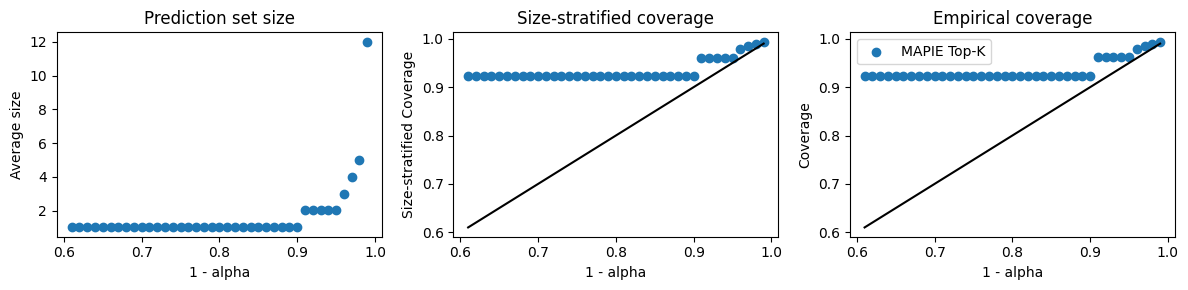

(0.9613636363636363,
 2.0048701298701297,
 0.9611745513866231,
 0,
 2.0048701298701297)

In [14]:
mapie_topkmapie = MapieClassifier(estimator=model, cv="prefit", method="top_k", random_state=3)
mapie_topkmapie.fit(X_calib, df_calibration['label'])
y_pred_topkmapie, y_ps_topkmapie = mapie_topkmapie.predict(X_test, alpha=alpha)

coverages_topkmapie = [
    classification_coverage_score(y_test, y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_topkmapie = [
    classification_mean_width_score(y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_topkmapie = [
    adjusted_classification_x_width_score(y_ps_topkmapie[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_topkmapie = [
    size_stratified_classification_coverage_score(y_test, y_ps_topkmapie[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_topkmapie, widths_mean_topkmapie, "MAPIE Top-K", ssc_topkmapie, True, "banking77", "bert")
coverages_topkmapie[target_index], widths_mean_topkmapie[target_index], ssc_topkmapie[target_index], set_size_equals(y_ps_topkmapie[:, :, target_index], 1), adjusted_width_topkmapie[target_index]

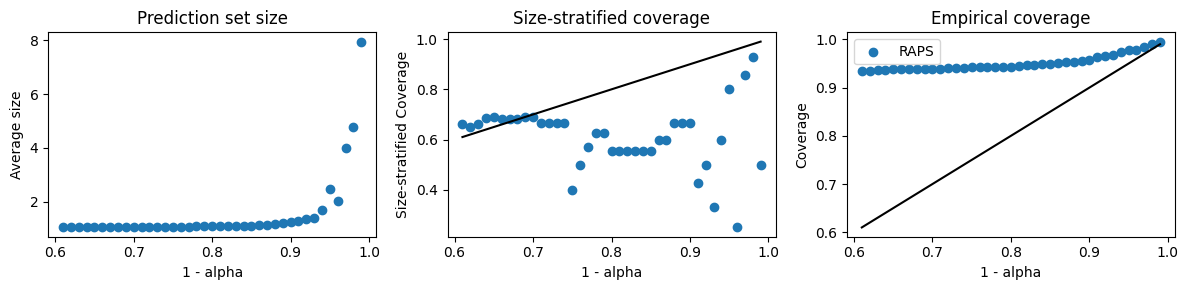

(0.9772727272727273, 2.4837662337662336, 0.8, 607, 2.4837662337662336)

In [15]:
mapie_raps = MapieClassifier(estimator=model, cv="prefit", method="raps")
mapie_raps.fit(X_calib, df_calibration['label'])
y_pred_raps, y_ps_raps = mapie_raps.predict(X_test, alpha=alpha)

coverages_raps = [
    classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
widths_mean_raps = [
    classification_mean_width_score(y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
adjusted_width_raps = [
    adjusted_classification_x_width_score(y_ps_raps[:, :, i], np.mean, max_ps_size)
    for i, _ in enumerate(alpha)
]
ssc_raps = [
    size_stratified_classification_coverage_score(y_test, y_ps_raps[:, :, i])
    for i, _ in enumerate(alpha)
]
plot.plot_coverages_widths(alpha, coverages_raps, widths_mean_raps, "RAPS", ssc_raps, True, "banking77", "bert")
coverages_raps[target_index], widths_mean_raps[target_index], ssc_raps[target_index], set_size_equals(y_ps_raps[:, :, target_index], 1), adjusted_width_raps[target_index]

In [16]:
topk_5 = TopKSelector(estimator=model, k=5)
y_ps_topk_5 = topk_5.predict(X_test)

coverages_topk_5 = classification_coverage_score(y_test, y_ps_topk_5)
widths_mean_topk_5 = classification_mean_width_score(y_ps_topk_5)
adjusted_width_topk_5 = adjusted_classification_x_width_score(y_ps_topk_5, np.mean, max_ps_size)
ssc_topk_5 = size_stratified_classification_coverage_score(y_test, y_ps_topk_5)

coverages_topk_5, widths_mean_topk_5, ssc_topk_5, set_size_equals(y_ps_topk_5, 1), adjusted_width_topk_5

(0.9883116883116884, 5.0, 0.9883116883116884, 0, 5.0)

In [17]:
top_95 = HeuristicCutoffSelector(estimator=model, cutoff=1-target_alpha)
y_ps_top_95 = top_95.predict(X_test)

coverages_top_95 = classification_coverage_score(y_test, y_ps_top_95)
widths_mean_top_95 = classification_mean_width_score(y_ps_top_95)
adjusted_width_top_95 = adjusted_classification_x_width_score(y_ps_top_95, np.mean, max_ps_size)
ssc_top_95 = size_stratified_classification_coverage_score(y_test, y_ps_top_95)

coverages_top_95, widths_mean_top_95, ssc_top_95, set_size_equals(y_ps_top_95, 1), adjusted_width_top_95

(0.9233766233766234, 1.0, 0.9233766233766234, 3080, 1.0)

In [18]:
set_size_equals(y_ps_top_95, 1)/y_ps_top_95.shape[0], y_ps_top_95[y_ps_top_95.sum(axis=1) > 1].sum(axis=1).mean()

/tmp/ipykernel_26236/933831444.py:1: RuntimeWarning: Mean of empty slice.
  set_size_equals(y_ps_top_95, 1)/y_ps_top_95.shape[0], y_ps_top_95[y_ps_top_95.sum(axis=1) > 1].sum(axis=1).mean()
/home/floris/anaconda3/envs/cicc/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


(1.0, nan)

In [19]:
top_5_95 = TopKCutoffSelector(estimator=model, cutoff=1-target_alpha, k=5)
y_ps_top_5_95 = top_5_95.predict(X_test)

coverages_top_5_95 = classification_coverage_score(y_test, y_ps_top_5_95)
widths_mean_top_5_95 = classification_mean_width_score(y_ps_top_5_95)
adjusted_width_top_5_95 = adjusted_classification_x_width_score(y_ps_top_5_95, np.mean, max_ps_size)
ssc_top_5_95 = size_stratified_classification_coverage_score(y_test, y_ps_top_5_95)
cq_size_top_5_85 = (y_ps_top_5_95.sum(axis=1) > 1)

coverages_top_5_95, widths_mean_top_5_95, ssc_top_5_95, set_size_equals(y_ps_top_5_95, 1), adjusted_width_top_5_95

(0.974025974025974,
 1.7324675324675325,
 0.9485815602836879,
 2516,
 1.7324675324675325)

In [20]:
set_size_equals(y_ps_top_5_95, 1)/y_ps_top_5_95.shape[0], y_ps_top_5_95[y_ps_top_5_95.sum(axis=1) > 1].sum(axis=1).mean()

(0.8168831168831169, 5.0)

In [21]:
y_ps_t = y_ps_top_5_95
cq_stats(y_ps_t, y_test, max_ps_size)

(0.974025974025974, 0.8168831168831169, 0.18311688311688312, 0.0, 5.0)

In [22]:
y_ps_t = y_ps_top_95
cq_stats(y_ps_t, y_test, max_ps_size)

/home/floris/projects/cicc/src/eval.py:110: UserWarning: Warning: converting a masked element to nan.
  return float(agg_width)


(0.9233766233766234, 1.0, 0.0, 0.0, nan)

In [23]:
y_ps_t = y_ps_topk_5
cq_stats(y_ps_t, y_test, max_ps_size)

(0.9883116883116884, 0.0, 1.0, 0.0, 5.0)

In [24]:
y_ps_t = y_ps_score[:, :, target_index]
cq_stats(y_ps_t, y_test, max_ps_size)

(0.9600649350649351,
 0.8883116883116883,
 0.11103896103896103,
 0.0006493506493506494,
 2.5794117647058825)

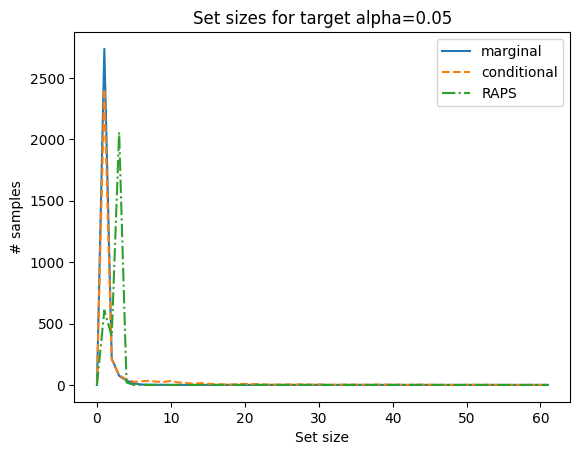

In [25]:
to_plot = [
    (y_ps_score, 'marginal', '-', None),
    (y_ps_cum, 'conditional', '--', None),
    (y_ps_raps, 'RAPS', '-.', None),
    # (y_ps_topkmapie, 'TOPK', ':', None),
    # (y_ps_top_5_95, 'heuristic a', 'dashed', 'black'),
    # (y_ps_top_95,  'heuristic b', 'dotted', 'black'),
    # (y_ps_topk_5,  'heuristic c', '-.', 'black'),
]
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    plt.plot([set_size_equals(to_plot_result, i) for i in range(62)], label=label, linestyle=style)
plt.xlabel('Set size')
plt.ylabel('# samples')
plt.title('Set sizes for target alpha={}'.format(target_alpha))
plt.legend()

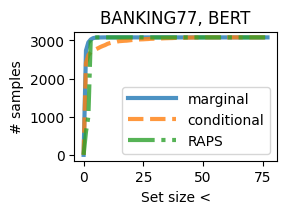

In [26]:
fig, ax = plt.subplots(1, 1, figsize=plot.fig_dim_1)
for (resultset, label, style, color) in to_plot:
    if len(label) > len('heuristic') and label[:len('heuristic')] == 'heuristic':
        to_plot_result = resultset
    else:
        to_plot_result = resultset[:, :, target_index]
    ax.plot(
        np.cumsum([set_size_equals(to_plot_result, i) for i in range(78)]),
        label=label,
        linestyle=style,
        color=color,
        linewidth=3,
        alpha=.8)
    # ax.set_xscale('log')
plt.xlabel('Set size <')
plt.ylabel('# samples')
plt.title('BANKING77, BERT'.format(target_alpha))
plt.legend(handlelength=3.5)
plt.tight_layout()
plt.savefig('results/cum_set_size_BANKING77_BERT.png', dpi=1200)

In [27]:
pd.Series(np.cumsum([set_size_equals(y_ps_score[:, :, target_index], i) for i in range(78)])).to_csv('results/score_b77_bert.csv')

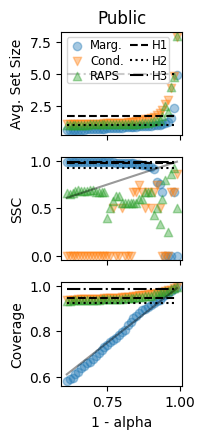

In [28]:
plot.plot_coverages_widths_multi(
    alpha,
    (coverages_score,
     coverages_cum,
     coverages_raps,
     # coverages_topkmapie,
    ),
    (widths_mean_score,
     widths_mean_cum,
     widths_mean_raps,
     widths_mean_topkmapie,
    ),
    # (adjusted_width_score,
    #  adjusted_width_cum,
    #  adjusted_width_raps,
     # adjusted_width_topkmapie,2
    # ),
    ('Marg.', 'Cond.', 'RAPS',),#'TOPK'),
    legend=(0, 'upper left'),
    sscs=(ssc_score,
     ssc_cum,
     ssc_raps,
     # ssc_topkmapie
    ),
    hlines=(
        (widths_mean_top_5_95, ssc_top_5_95, coverages_top_5_95,  'H1', 'dashed'),
        (widths_mean_top_95, ssc_top_95, coverages_top_95,  'H2', 'dotted'),
        (widths_mean_topk_5, ssc_topk_5, coverages_topk_5,  'H3', '-.'),
    ),
    plot_ssc=True,
    markers=('o', 'v', '^',),
    dataset='BANKING77',
    model='BERT',
    title='Public')

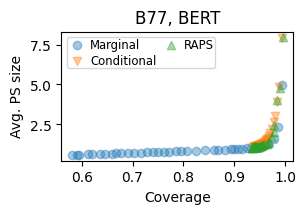

In [29]:
plot.plot_cov_x_width_multi(
    alpha,
    (coverages_score,
     coverages_cum,
     coverages_raps,
     # coverages_topkmapie,
    ),
    (widths_mean_score,
     widths_mean_cum,
     widths_mean_raps,
     widths_mean_topkmapie,
    ),
    # (adjusted_width_score,
    #  adjusted_width_cum,
    #  adjusted_width_raps,
    # adjusted_width_topkmapie,
    # ),
    # (cq_width_score,
    #  cq_width_cum,
    #  cq_width_raps,
    #  # cq_width,topkmapie,
    # ),
    ('Marginal', 'Conditional', 'RAPS',),#,'TOPK'),
    legend=(0, 'upper left'),
    sscs=(ssc_score,
     ssc_cum,
     ssc_raps,
    # ssc_topkmapie
    ),
    plot_ssc=False,
    # hlines=(
    #     (cq_width_top_5_95, ssc_top_5_95, coverages_top_5_95,  'H1', 'dashed'),
    #     (cq_width_top_95, ssc_top_95, coverages_top_95,  'H2', 'dotted'),
    #     (cq_width_topk_5, ssc_topk_5, coverages_topk_5,  'H3', '-.'),
    # ),
    markers=('o', 'v', '^',),
    dataset='B77',
    model='BERT',)

In [31]:
y_ps_which = y_ps_score
ambiguous = np.where((y_ps_which[:, :, target_index].sum(axis=1) >= 6))
bert_ambiguous = df_test.loc[ambiguous]
list(zip(bert_ambiguous.index,[ labels[l] for l in bert_ambiguous.label.tolist()], bert_ambiguous.text.tolist()))

[(301,
  'card_delivery_estimate',
  'Ordered awhile back, what is the ETA in the US?'),
 (345,
  'automatic_top_up',
  'Can I space out how often money is transferred along my travels?'),
 (606,
  'top_up_by_bank_transfer_charge',
  'I would like to refill my account using SWIFT.'),
 (1321,
  'topping_up_by_card',
  'WHERE IS MY MONEY I WAS USING MY CARD AND IT DISAPPEARED'),
 (1622,
  'pending_card_payment',
  'How long do card transactions take to clear?'),
 (1751, 'declined_transfer', 'Double check your funds may be declined'),
 (3058, 'country_support', 'Where can I find your locations?')]

In [34]:
for ba in bert_ambiguous.index:
    alternatives = np.where(y_ps_which[ba, :, target_index])[0]
    print(" & ".join([bert_ambiguous.loc[ba].text, labels[bert_ambiguous.loc[ba].label].replace("_", " "), ', '.join([labels[l].replace("_", " ") for l in alternatives])]) + " \\\\")

Ordered awhile back, what is the ETA in the US? & card delivery estimate & card payment not recognised, country support, exchange rate, fiat currency support, pending card payment, verify my identity, why verify identity \\
Can I space out how often money is transferred along my travels? & automatic top up & balance not updated after bank transfer, exchange charge, exchange rate, transfer into account, transfer timing, wrong exchange rate for cash withdrawal \\
I would like to refill my account using SWIFT. & top up by bank transfer charge & automatic top up, supported cards and currencies, top up by card charge, top up by cash or cheque, top up limits, topping up by card \\
WHERE IS MY MONEY I WAS USING MY CARD AND IT DISAPPEARED & topping up by card & card swallowed, cash withdrawal not recognised, compromised card, declined cash withdrawal, lost or stolen card, lost or stolen phone, top up by cash or cheque, top up reverted, verify source of funds \\
How long do card transactions ta

In [ ]:
df_test

In [ ]:
np.unique(y_ps_score[:, :, target_index].sum(axis=1), return_counts=True)

In [ ]:
df_test.loc[ambiguous_indices_dfcx_cum[0]].text

In [ ]:
for ba in ambiguous_indices_dfcx_cum:
    print(" & ".join([df_test.loc[ba].text, labels[df_test.loc[ba].label].replace("_", " ")]) + " \\\\")

In [ ]:
df_test.loc[(y_ps_score[:, :, target_index].sum(axis=1) > 4)]

In [36]:
ambiguous_indices_dfcx_cum = [7,
 27,
 42,
 43,
 45,
 56,
 66,
 68,
 80,
 81,
 85,
 100,
 106,
 114,
 120,
 121,
 128,
 138,
 143,
 147,
 153,
 171,
 175,
 182,
 192,
 199,
 200,
 205,
 206,
 210,
 216,
 279,
 290,
 291,
 314,
 317,
 321,
 329,
 333,
 338,
 343,
 345,
 346,
 358,
 372,
 374,
 388,
 396,
 398,
 407,
 409,
 410,
 414,
 422,
 423,
 436,
 444,
 452,
 462,
 467,
 471,
 477,
 479,
 491,
 514,
 519,
 531,
 535,
 536,
 557,
 581,
 587,
 591,
 594,
 598,
 619,
 626,
 627,
 632,
 637,
 641,
 663,
 674,
 675,
 679,
 680,
 683,
 688,
 693,
 707,
 710,
 713,
 727,
 728,
 730,
 737,
 739,
 746,
 757,
 760,
 768,
 776,
 780,
 786,
 787,
 795,
 798,
 826,
 837,
 843,
 845,
 849,
 858,
 861,
 865,
 869,
 876,
 882,
 902,
 906,
 913,
 920,
 923,
 932,
 937,
 955,
 957,
 960,
 970,
 977,
 983,
 1006,
 1011,
 1015,
 1016,
 1021,
 1028,
 1031,
 1036,
 1040,
 1041,
 1070,
 1076,
 1078,
 1084,
 1102,
 1110,
 1116,
 1119,
 1127,
 1132,
 1148,
 1152,
 1164,
 1165,
 1179,
 1187,
 1202,
 1214,
 1217,
 1221,
 1239,
 1250,
 1256,
 1259,
 1263,
 1264,
 1269,
 1274,
 1279,
 1287,
 1291,
 1292,
 1293,
 1295,
 1300,
 1316,
 1317,
 1320,
 1322,
 1360,
 1362,
 1374,
 1378,
 1382,
 1404,
 1424,
 1425,
 1426,
 1430,
 1442,
 1459,
 1463,
 1467,
 1477,
 1478,
 1481,
 1485,
 1494,
 1495,
 1499,
 1510,
 1516,
 1539,
 1557,
 1565,
 1595,
 1623,
 1633,
 1663,
 1666,
 1693,
 1704,
 1714,
 1716,
 1732,
 1733,
 1747,
 1757,
 1758,
 1769,
 1772,
 1778,
 1791,
 1817,
 1821,
 1824,
 1827,
 1829,
 1831,
 1832,
 1837,
 1838,
 1843,
 1849,
 1854,
 1857,
 1865,
 1869,
 1876,
 1879,
 1881,
 1887,
 1893,
 1896,
 1904,
 1905,
 1908,
 1915,
 1916,
 1921,
 1935,
 1943,
 1956,
 1962,
 1965,
 1972,
 1973,
 1995,
 2017,
 2042,
 2054,
 2062,
 2081,
 2084,
 2088,
 2097,
 2105,
 2116,
 2117,
 2121,
 2129,
 2134,
 2135,
 2143,
 2158,
 2167,
 2173,
 2175,
 2177,
 2195,
 2196,
 2203,
 2225,
 2232,
 2254,
 2268,
 2274,
 2286,
 2292,
 2303,
 2304,
 2306,
 2311,
 2313,
 2321,
 2329,
 2332,
 2345,
 2361,
 2364,
 2367,
 2374,
 2378,
 2415,
 2422,
 2424,
 2435,
 2437,
 2438,
 2439,
 2442,
 2452,
 2463,
 2472,
 2480,
 2489,
 2490,
 2491,
 2499,
 2510,
 2520,
 2522,
 2556,
 2563,
 2572,
 2574,
 2581,
 2588,
 2595,
 2603,
 2613,
 2628,
 2629,
 2631,
 2633,
 2639,
 2645,
 2646,
 2662,
 2667,
 2670,
 2692,
 2701,
 2711,
 2718,
 2743,
 2763,
 2765,
 2766,
 2770,
 2776,
 2814,
 2815,
 2816,
 2819,
 2821,
 2823,
 2830,
 2833,
 2850,
 2851,
 2856,
 2861,
 2862,
 2865,
 2872,
 2878,
 2880,
 2891,
 2892,
 2894,
 2895,
 2902,
 2919,
 2926,
 2928,
 2929,
 2930,
 2941,
 2942,
 2945,
 2953,
 2956,
 2965,
 2972,
 2976,
 2977,
 2979,
 2981,
 2992,
 3011,
 3015,
 3025,
 3029,
 3056,
 3059,
 3063,
 3064,
 3065,
 3076]

In [37]:
label_sorting_map = {i: x for x, i in enumerate(df_train.label.value_counts(sort=True).index)}

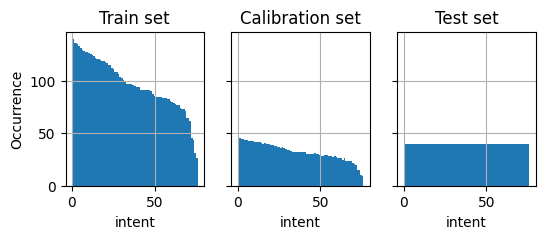

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(plot.fig_width_in * 2, 2), sharey=True)
pd.Series(list(map(lambda x: label_sorting_map[x], df_train.label, ))).hist(bins=N_INTENTS, ax=axs[0])
pd.Series(list(map(lambda x: label_sorting_map[x], df_calibration.label, ))).hist(bins=N_INTENTS, ax=axs[1])
pd.Series(list(map(lambda x: label_sorting_map[x], df_test.label, ))).hist(bins=N_INTENTS, ax=axs[2])
titles = ['Train set', 'Calibration set', 'Test set']
[ax.set_xlabel('intent') for ax in axs]
[ax.set_title(title) for (ax, title) in zip(axs, titles)]
axs[0].set_ylabel('Occurrence')
# plt.yticks([]) 
plt.savefig('results/label_distribution_banking77.png', dpi=1200)
plt.show()